<h1><center>Logvinenko, Denis – Neural Networks – Project</center></h1>

<h2><center>Controlling Linguistic Style Aspects in Neural Language Generation</center></h2>

### Useful links:

1. [Amazon movie reviews dataset](https://snap.stanford.edu/data/web-Movies.html)
2. [Rotten Tomatoes critic reviews](https://github.com/nicolas-gervais/rotten-tomatoes-dataset)

#### 0.1.0 All imports (we don't need everything from this list for training):

In [1]:
from collections import Counter, defaultdict
import numpy as np; np.random.seed(42)
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import youtokentome as yttm
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import subprocess
import itertools
import operator
import os, sys
import random
import shutil
import spacy; from spacy.lang.en import English
import json
import time
import re
import gc

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
pd.set_option('display.max_rows', None)

#### 0.2 Standard paths:

In [2]:
amazon_movies = 'amazon_movies.txt'
corpus_small = 'corpus_small.csv'
corpus_small_annotated = 'corpus_small_annotated.csv'
csa_json = 'corpus_small_annotated.json'
sentences = 'sentences.txt'
bpe_model = 'bpe.model'
bpe_model_small = 'bpe10K.model'
bpe_model_medium = 'bpe20K.model'

#### 0.3 Auxiliary functions:

In [3]:
def save_to_path(path, extension_of_old='.txt', extension_of_new='.csv') -> str:
    """
    Function checks if some file in path already exists and if so, it adds an
    index before the extension.
    
    Function has 2 further parameters:
        extension_of_old --> defines the extension of the original file
        extension_of_new --> defines the extension of the new file to be saved
        
    returns the new save path
    """
    
    m = re.match(f'(.+){extension_of_old}?', path)
    save_path = m.group(1) + f'{extension_of_new}'    
    j = 1
    while os.path.isfile(save_path):       
        save_path = m.group(1) + f'{j}{extension_of_new}'
        j += 1
        
    return save_path

<h3><center>1. Obtaining and preprocessing corpus</center></h3>

#### 1.0 Checking for incomplete entries in the Amazon corpus:

(There could have been entries, where not all necessary metadata were available)

In [4]:
def check_incomplete_entries(path, categories=None):
    """
    This function shows if there are some entries, which we wouldn't 
    want to add because of the missing metadata
    """    
    if categories is None:
        categories = ['review/userId', 'review/score', 'review/text']
        
    notfull, full = 0, 0
    current_cat_list = []
    
    with open(path) as f:
        for line in f:
            if sorted(categories) == sorted(current_cat_list):
                full += 1
                current_cat_list = [] 
            for cat in categories:
                if cat in line:
                    current_cat_list.append(cat)
    
    print(f'Complete Entries: {full}, Incomplete Entries: {7911684-full}')
    
check_incomplete_entries(amazon_movies)

Complete Entries: 7911684, Incomplete Entries: 0


In [5]:
def num_entries(path, categories=None):
    """
    This function shows that 'line == '\n'' is a really bad counter for reviews  
    """
    if categories is None:
        categories = ['review/userId', 'review/score', 'review/text']
        
    rev_count, empty = 0, 0
    
    with open(path) as f:        
        for line in f:
            if 'product/productId:' in line:
                rev_count += 1
            elif line == '\n':
                empty += 1
    
    print(f'Empty Lines: {empty}, Number of reviews: {rev_count}')
    
num_entries(amazon_movies)

Empty Lines: 7911696, Number of reviews: 7911684


#### 1.1 Collecting information about user review counts:

In [6]:
def get_ids_stat(path, prof_min=100):
    
    stat_ids = defaultdict(int)        
    with open(path) as f:
        for line in f:
            if 'review/userId:' in line:
                user_id = line.split()[1]
                stat_ids[user_id] += 1
    idx = []
    i = 1
    with open(path) as f:
        for line in f:
            if 'review/userId:' in line:
                user_id = line.split()[1]
                if stat_ids[user_id] >= prof_min:
                    idx.append(i)
                i += 1
    stat_ids = [(user_id, count) for user_id, count in sorted(stat_ids.items(), key=lambda x: x[1])]
    return stat_ids, idx

stat_ids, idx = get_ids_stat(amazon_movies)
stat_dict = dict(stat_ids)

with open('stat_dict.json', 'w') as f:
    json.dump(stat_dict, f)

print(f'Number of reviews that were written by users with >= 100 reviews: {len(idx)}')

user_max_review_count = stat_ids[-1][1]

print(f'Maximum number of reviews that a user ever wrote: {user_max_review_count}')

Number of reviews that were written by users with >= 100 reviews: 2551393
Maximum number of reviews that a user ever wrote: 10793


In [7]:
with open('stat_dict.json') as f:
    stat_dict = json.load(f)

In [7]:
# shows the number of reviewers with more than 100 reviews:
sum([1 for key, value in stat_dict.items() if value>100])

7103

#### 1.2 Converting corpus to csv:

In [33]:
def convert_txt_to_csv(path, categories=None, num_reviews=100000, prof_idx=idx):
    """
    7911684 - total number of reviews in the Amazon corpus.
    
    Because the resulting file is too large (approx. 6 GB), 
    we choose only a fraction of reviews (resulting in only 85 MB),
    where 50% of entries come from professional reviewers and the rest
    from users who wrote less than 100 reviews
    """
    
    t = time.time()
    if categories is None:
        categories = ['review/userId', 'review/score', 'review/text']
    
    prof_indices_pool = np.asarray(prof_idx)
    array1 = np.arange(start=1, stop=7911685)    
    non_prof_indices_pool = np.setdiff1d(array1, prof_indices_pool) # Unique values in array1 that are not in indices_prof    
    
    rng = np.random.default_rng(42)
    indices_non_prof = rng.choice(non_prof_indices_pool, size=num_reviews//2, replace=False)
    indices_prof = rng.choice(prof_indices_pool, size=num_reviews-len(indices_non_prof), replace=False)
    print(f'Selected {len(indices_non_prof)} non-prof reviews and {len(indices_prof)} prof reviews...')
    
    indices = np.sort(np.concatenate((indices_non_prof, indices_prof)))
    content_dict = {cat:[] for cat in categories}
    user_cat_counter, rev_count, i = 0, 0, 0
    current_user = []    
    added = True 
      
    with open(path) as f:        
        for line in f:
            if i == num_reviews:
                break
            if 'product/productId:' in line:
                rev_count += 1
                if not added:                    
                    i += 1
                    user_cat_counter = 0
                    current_user = []
                    added = True                    
                continue                
                
            if rev_count == indices[i]:
                added = False
                for cat in categories:
                    if cat in line:
                        user_cat_counter += 1
                        current_user.append((cat, line.split(':')[1].strip()))
                        
                if user_cat_counter == len(categories):
                    added = True
                    i += 1
                    for key, val in current_user:
                        content_dict[key].append(val)
                    user_cat_counter = 0
                    current_user = []     
            
    df = pd.DataFrame()
    for key in content_dict:
        df[key] = content_dict[key]
        
    save_path = 'corpus_small.csv'
    df.to_csv(save_path, index=False, header=False, sep='\t')
    
    print(f'Done: {time.time()-t:.2f}s elapsed!')

In [34]:
convert_txt_to_csv(amazon_movies, prof_idx=idx)

Selected 50000 non-prof reviews and 50000 prof reviews...
Done: 63.90s elapsed!


#### 1.3 Showing how many users there are in each reviews count bin and checking if proportion of professional/unprofessional reviews is 1:1:

In [35]:
ids_small = set()
stat_dict = dict(stat_ids)
prof, unprof = 0, 0

with open(corpus_small, encoding='utf-8') as f:
    for line in f:
        user_id = line.split('\t')[0]
        if stat_dict[user_id] >= 100:
            prof += 1
        else:
            unprof += 1
        if user_id not in ids_small:
            ids_small.add(user_id)
            
stat_ids_small = [(user_id, count) for user_id, count in stat_ids if user_id in ids_small]

print(f'Number of professional reviews in the small corpus: {prof}')
print(f'Number of unprofessional reviews in the small corpus: {unprof}')
print(f'Number of users in the small corpus: {len(stat_ids_small)}')

Number of professional reviews in the small corpus: 50000
Number of unprofessional reviews in the small corpus: 50000
Number of users in the small corpus: 52779


Bin 1-20	31829 users
Bin 21-40	7951 users
Bin 41-60	3225 users
Bin 61-80	1792 users
Bin 81-100	1175 users
Bin 100-10793	6807 users


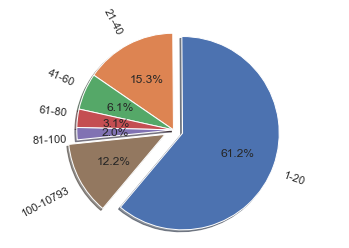

In [59]:
def show_rev_count_dist(stat_ids, end=100, step=20, maximum=user_max_review_count):
    """
    The function generates a plot that shows the proportions of how many people wrote that many reviews
    """
    xy = {f'{i}-{i+step-1}':0 for i in range(1,end,step)}
    xy[f'{end}-{maximum}'] = 0   
    
    most_common_users = stat_ids[::-1]        
    for user_id, count in most_common_users:
        for rng in xy:
            splitted = rng.split('-')
            lower = int(splitted[0])
            upper = int(splitted[1])
            if count >= lower and count <= upper:
                xy[rng] += 1
                break
                
    total_count = 0
    for abin, count in xy.items():
        print(f'Bin {abin}\t{count} users')
        total_count += count

    sizes = [int(100*count/total_count) for abin, count in xy.items()]
    explode = (0.1, 0, 0, 0, 0, 0.1)
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=list(xy.keys()), autopct='%1.1f%%', 
            shadow=True, startangle=230, rotatelabels=True)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
show_rev_count_dist(stat_ids_small)

<h3><center>2. Obtaining metadata for conditioning LM</center></h3>

#### 2.0 Checking the score range:
(to make sure the scores range from 1 to 5)

In [65]:
def show_score_range(path_to_csv):
    scores = set()
    failed = 0
    failed_list = []
    
    with open(path_to_csv) as f:
        for line in f:
            splitted = line.split('\t')
            try:
                score = float(splitted[1])
                if score not in scores:
                    scores.add(score)
            except ValueError:
                failed += 1
                failed_list.append(splitted[1])
                
    print(f'Scores: {scores}\nFailed: {failed}, Examples: {failed_list}')
    
show_score_range(corpus_small)

Scores: {1.0, 2.0, 3.0, 4.0, 5.0}
Failed: 0, Examples: []


#### 2.1 Collecting metadata:

In [5]:
class MetadataExtractor:
    """
    Extracts following metadata from the review sentences (18 labels in total):
    
    !!! DISCLAIMER:
    NOTE: '0' IS NOT USED BECAUSE IT IS RESERVED FOR PADDING SUBWORD TOKENS
    !!!
    
        1. If the reviewer is a professional:
            - based on "stat_dict" from section 1.1:
                False -> '1'
                True -> '2'
        2. Sentiment:
            - negative (1, 2 -> '3'), neutral (3 -> '4'), positive (4, 5 -> '5') 
        3. Length in tokens:
            - ≤10 -> '6', 11-20 -> '7', 21-40 -> '8', >40 -> '9'
        4. Personal:
            - True (if ('I' or 'my') in sentence) -> '11', False (otherwise) -> '10'
        5. Theme:
            - '12' - plot, '13' - acting, '14' - production, '15' - effects, '16' - other (based on word lists)
        6. Descriptive:
            - True (if 35% POS-tags are ADJ) -> Bad boundary, changed to 25% -> '18'
            - False -> '17'
    """
    
    def __init__(self, path, path_to_themes, path_to_stat_dict='stat_dict.json'):
        self.path = path
        
        with open(path_to_themes) as f:
            text = f.read().split('\n')
            self.theme2int = {'plot':'12', 'acting':'13', 'production':'14', 'effects':'15'}            
            self.themes_dict = {theme_word:self.theme2int[theme_word_list.split(',')[0]]
                                for theme_word_list in text for theme_word in theme_word_list.split(',')[1:]} 
            
        self.nlp = spacy.load('en_core_web_sm')
        self.no_model_nlp = English()
        self.sentencizer = self.no_model_nlp.create_pipe('sentencizer')
        self.no_model_nlp.add_pipe(self.sentencizer)
        
        with open(path_to_stat_dict) as f:
            self.stat_dict = json.load(f)
        self.transl_table = str.maketrans(';123456789', '.000000000', 
                                          rf'"#%()*+/:=>@[\]_`|{chr(147)}{chr(148)}§«º»№')
        
        self.pat1 = re.compile('<.*?>')
        self.pat2 = re.compile('&.*?;')
    
    def clean_review(self, review):        
        review = self.pat1.sub('', review) # deletes all '<br />'-like markdown        
        review = self.pat2.sub('', review) # deletes some other md
        review = review.translate(self.transl_table)
        review = review.replace(' --', ',').replace('""', '"').replace('  ', ' ')
        
        return review
    
    def split_into_sents(self, review):        
        doc = self.no_model_nlp(review)
        sents = [sent.text for sent in doc.sents]

        return sents
    
    def ext_professional(self, pro, num_sents):
        return [str(int(self.stat_dict[pro] >= 100) + 1)]*num_sents
    
    def ext_sentiment(self, score, num_sents):
        if score == '4.0' or score == '5.0':
            sentiment = '5'
        elif score == '3.0':
            sentiment = '4'
        else:
            sentiment = '3'
        return [sentiment]*num_sents
    
    def ext_length(self, review_sents_tokens):
        """≤10, 11-20, 21-40, >40"""
        length = []
        
        for sent_tokens in review_sents_tokens:
            num_tokens = len(sent_tokens)
            if num_tokens <= 10:
                length.append('6')
            elif num_tokens >= 11 and num_tokens <= 20:
                length.append('7')
            elif num_tokens >= 21 and num_tokens <= 40:
                length.append('8')
            else:
                length.append('9')
                
        return length  
    
    def ext_personal(self, review_sents_tokens):
        """'11' - personal, '10' - not personal"""
        personal_markers = set(['I', 'my', 'i'])
        personal = []
        for sent in review_sents_tokens:
            found = False
            for token in sent:
                if token in personal_markers:
                    personal.append('11')
                    found = True
                    break
            if not found:
                personal.append('10')
        return personal
    
    def ext_themes(self, review_sents_tokens):
        """'12' - plot, '13' - acting, '14' - production, '15' - effects, '16' - other"""
        themes = []
        for sent_tokens in review_sents_tokens:
            theme_counter = {theme:0 for theme in set(self.themes_dict.values())}
            for token in sent_tokens:
                if token in self.themes_dict:
                    theme_counter[self.themes_dict[token]] += 1

            best_theme = max(theme_counter.items(), key=operator.itemgetter(1))
            if best_theme[1] == 0:
                themes.append('16')
            else: 
                themes.append(best_theme[0])
        
        return themes
    
    def ext_descriptive(self, review_pos_list, descr_boundary=0.25):
        """'1' - descriptive, '0' - not descriptive"""
        descriptive = [str(int(sent_pos.count('ADJ')/len(sent_pos)>=descr_boundary)+17) # 16 labels before this one + 1 reserved
                       for sent_pos in review_pos_list]
        return descriptive        
            
    def extract_all(self, save_to='corpus_small_annotated.csv', plot_length=True):
        """Extracts all necessary metadata using some small helper-functions"""
        corpus_dict = {'sents_by_reviews':[],
                       'meta_by_reviews':[]}
        if plot_length:
            length_list = []            
            
        with open(save_to, 'w', encoding='utf-8', errors='ignore') as csv:
            print('Review', 'Sentence', 'Professional', 'Sentiment', 'Length', 'Personal', 'Theme', 'Descriptive', file=csv, sep='\t')
            idx = 0
            with open(self.path, encoding='utf-8', errors='ignore') as f:
                for _, line in zip(tqdm(range(100000)), f): # uncomment!
                #for i in range(500): # delete!
                    #line = next(f)# delete!
                    split_line = line.split('\t')
                    if len(split_line[-1]) > 1:
                        review = self.clean_review(split_line[-1])               
                        review_sents = self.split_into_sents(review)
                        review_sents = [sent.strip() for sent in review_sents if sent.strip()]

                        docs = list(self.nlp.pipe(review_sents, disable=['parser', 'ner', 'textcat']))
                        review_pos_list = [[token.pos_ for token in doc] for doc in docs]
                        review_sents_tokens = [[token.text for token in doc] for doc in docs]
                        num_sents = len(review_sents)

                        rev_pro = self.ext_professional(split_line[0], num_sents)
                        rev_senti = self.ext_sentiment(split_line[1], num_sents)
                        rev_length = self.ext_length(review_sents_tokens)
                        rev_pers = self.ext_personal(review_sents_tokens)
                        rev_theme = self.ext_themes(review_sents_tokens)
                        rev_descr = self.ext_descriptive(review_pos_list)

                        if plot_length:
                            length_list += [len(sent_tokens) for sent_tokens in review_sents_tokens]
                            
                        review_sents = [sent.lower() for sent in review_sents]
                        for data in zip(review_sents, rev_pro, rev_senti, rev_length, rev_pers, rev_theme, rev_descr):
                            data_list = '\t'.join(list(data))
                            line_to_print = f'{idx}\t{data_list}'
                            print(line_to_print, file=csv)
                            
                        corpus_dict['sents_by_reviews'].append(review_sents)
                        corpus_dict['meta_by_reviews'].append([])
                        for meta in zip(rev_pro, rev_senti, rev_length, rev_pers, rev_theme, rev_descr):
                            meta_list = list(meta)
                            meta_list =  [int(el) for el in meta_list]
                            corpus_dict['meta_by_reviews'][-1].append(meta_list)

                        idx += 1
        with open(save_to_path(save_to, extension_of_old='.csv', extension_of_new='.json'), 'w') as f:
            json.dump(corpus_dict, f)
            
        if plot_length:        
            fig, ax = plt.subplots(figsize=(8,6))
            length_list = np.log(np.array(length_list))/np.log(2)
            
            hist, bin_edges = np.histogram(length_list)
            bin_edges = np.round(bin_edges, 0)
            
            #n, bins, patches = ax.hist(length_list, bins='auto', density=False, alpha=0.75, color='g', rwidth=0.85)
            ax.bar(bin_edges[:-1], hist, alpha=0.75, color='g')
            
            ticks = list(range(9))
            ax.set_xlim(min(bin_edges), 9) # 2**9 = 512
            ax.set_xticks(ticks)
            ax.set_xlabel('log2(Length of Sentences)')
            ax.set_ylabel('Frequency')
            
            plt.savefig('length_hist.png')
            plt.show()

100%|██████████████████████████████████████████████████████| 100000/100000 [30:12<00:00, 55.19it/s]


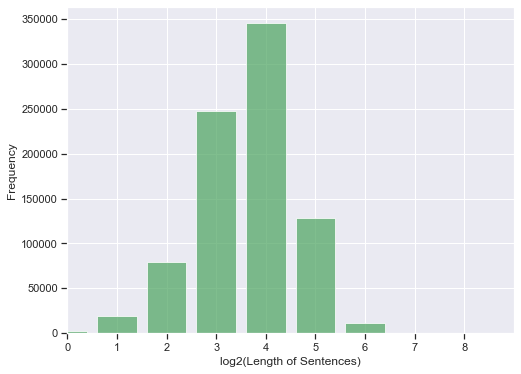

In [6]:
ext = MetadataExtractor(path=corpus_small, path_to_themes='themes.txt')
ext.extract_all(save_to=corpus_small_annotated, plot_length=True)

<h3><center>3. Some preprocessing before creating an LM</center></h3>

#### 3.0.1 Loading the annotated corpus:

In [6]:
sentences_df = pd.read_csv(corpus_small_annotated, sep='\t', header=0, 
                           encoding='utf-8', warn_bad_lines=True, index_col=0)
sentences_df['Sentence'] = sentences_df['Sentence'].astype(str).str.lower()

sentences_df.head(3)

,Sentence,Professional,Sentiment,Length,Personal,Theme,Descriptive
Review,,,,,,,
0,"i have the doo wop 00 and 00 dvds, and was anx...",1,5,8,11,16,17
0,"from the first video, which featured the crme ...",1,5,8,10,14,17
0,"better lighting, better stage layout, and bett...",1,5,7,10,15,18


#### 3.0.2 Showing some statistics about collected metadata:

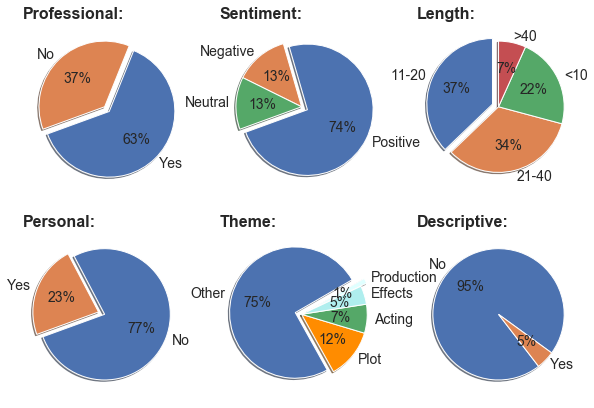

In [5]:
""" Plotting with standard labels:
fig, ax = plt.subplots(figsize=(10, 7))
ax.axis("off")

for i, col in enumerate(sentences_meta.columns, 1):
    new_ax = fig.add_subplot(2, 3, i)
    plot = sentences_meta[col].value_counts().plot.pie(autopct='%1.1f%%', 
                                                       shadow=True)
    new_ax.set_title(col, loc='left', fontsize=14)
    new_ax.set_ylabel(None)

plt.show()
"""
sentences_meta = sentences_df.iloc[:, 1:]
fig, ax = plt.subplots(figsize=(10, 7))
ax.axis("off")

# Ordering determined empirically by plotting with standard labels:
labels = [['Yes', 'No'], # Professional
          [ 'Positive', 'Negative', 'Neutral'], # Sentiment
          ['11-20', '21-40', '<10', '>40'], # Length
          ['No', 'Yes'], # Personal
          ['Other', 'Plot', 'Acting', 'Effects', 'Production'], # Theme: '0' - plot, '1' - acting, '2' - production, '3' - effects, '4' - other"""
          ['No', 'Yes']] # Descriptive

rotatelabels = [False, False, False, False, False, False]
startangle = [200, 200, 90, 200, 30, 324] # 90 for 3rd
explode = [(0.1, 0), (0.1, 0, 0), (0.1, 0, 0, 0), (0, 0.1), (0.1, 0, 0, 0, 0.1), (0, 0)]
colors = [None, None, None, None, [None, 'darkorange', 'g', 'paleturquoise', 'lightcyan'], None]

for i, col in enumerate(sentences_meta.columns):
    new_ax = fig.add_subplot(2, 3, i+1)
    plot = sentences_meta[col].value_counts().plot.pie(autopct='%1.0f%%', 
                                                       shadow=True,
                                                       explode=explode[i],
                                                       labels=labels[i],
                                                       colors=colors[i],
                                                       startangle=startangle[i], 
                                                       rotatelabels=rotatelabels[i],
                                                       fontsize=14)
    new_ax.set_title(col +':', loc='left', fontsize=16, fontweight='bold')
    new_ax.set_ylabel(None)

plt.show()   

#### 3.0.3 Creating dictionary using Byte Pair Encoding (Sennrich (2016) algorithm):

In [6]:
class BytePairEncoding:
    """
    A method to deal with a huge vocabulary by dividing words into subwords
    and then consequently merging the most frequent pair of subwords into 
    one subword.
    
    vocab_size=30469 <- this value is used in Ficler, Goldberg (2017)
    
    The implementation follows precisely Sennrich (2016).
    """
    
    def __init__(self, sents):
        self.sents = sents
        self.final_dict = None
        
    def __get_vocab(self, sents) -> dict:
        
        words = [' '.join(word) + ' </w>' for sentence in sents
                 for word in sentence.split()]
        
        return Counter(words)
    
    def __get_pair_counts(self, vocab) -> dict:
        
        pairs_dict = defaultdict(int)
        for word, freq in vocab.items():
            letters = word.split()
            for i in range(len(letters)-1):
                pairs_dict[(letters[i], letters[i+1])] += freq
                
        return pairs_dict
    
    def __merge_most_freq_pair(self, pair, vocab_to_update):
        vocab_updated = {}
        #pairs_sorted = [(pair, freq) for pair, freq in sorted(pairs_dict.items(), key=lambda x:x[1], reverse=True)]
    
        pair_escaped = re.escape(' '.join(pair))
        pat = re.compile(r'(?<!\S)' + pair_escaped + r'(?!\S)')

        for word in vocab_to_update:
            # replace most frequent pair in all vocabulary
            word_updated = pat.sub(''.join(pair), word)
            vocab_updated[word_updated] = vocab_to_update[word]
            
        return vocab_updated
    
    def encode(self, num_iter=50, save_json=True):
        
        vocab_to_update = self.__get_vocab(self.sents)
        print(f'Raw vocabulary length: {len(vocab_to_update)}')
        pairs_dict_lenghts = []      
        
        for i in range(num_iter):
            pairs_dict = self.__get_pair_counts(vocab_to_update)
            pairs_dict_lenghts.append(len(pairs_dict))
            if not pairs_dict :
                print('No pairs found in the provided corpus!', file=sys.stderr)
                
            most_freq_pair = max(pairs_dict, key=pairs_dict.get)
            vocab_to_update = self.__merge_most_freq_pair(most_freq_pair, vocab_to_update)
            
        print(f'Pairs at the start: {pairs_dict_lenghts[0]}\nPairs at the end: {pairs_dict_lenghts[-1]}')    
        if save_json:
            with open('bytepairvocab.json', 'w') as f:
                json.dump(vocab_to_update, f)
                
        #return vocab_to_update

In [7]:
bytepair = BytePairEncoding(sentences_df['Sentence'])
bytepair.encode(num_iter=1, save_json=False)

Raw vocabulary length: 330686
Pairs at the start: 1617
Pairs at the end: 1617


#### 3.1 Creating dictionary using a faster BPE algorithm:

In [7]:
vocab_size = 30469 # 30469 - standard, 10000 - small, 20000 - medium
with open(csa_json) as f:
    revs = json.load(f)['sents_by_reviews']
    
revs = [sent for rev in revs for sent in rev]

with open(sentences, 'w', encoding='utf-8') as f:
    for sent in revs:
        f.write(sent + ' ')
del revs

command = f'yttm bpe --data {sentences} --model {bpe_model} --vocab_size {vocab_size}' # bpe_model
subprocess.run(command, check=True)

CompletedProcess(args='yttm bpe --data sentences.txt --model bpe.model --vocab_size 30469', returncode=0)

#### Some encoding/decoding usage example:

In [8]:
# Loading model
bpe = yttm.BPE(model=bpe_model)
test_text = ['i have the doo wop 00 and 00 dvds' , 'i have no idea if this is']

# Two types of tokenization
print(bpe.encode(test_text, output_type=yttm.OutputType.ID))
print(bpe.encode(test_text, output_type=yttm.OutputType.SUBWORD))
print(bpe.decode([254, 123])[0])  
print(''.join([bpe.id_to_subword(254), bpe.id_to_subword(123)])) # that is why we will use bpe.decode instead to circumvent generating '▁' before a subword

[[86, 216, 87, 9060, 90, 262, 252, 109, 252, 3269], [86, 216, 336, 1715, 298, 138, 122]]
[['▁i', '▁have', '▁the', '▁doo', '▁w', 'op', '▁00', '▁and', '▁00', '▁dvds'], ['▁i', '▁have', '▁no', '▁idea', '▁if', '▁this', '▁is']]
fromom
▁fromom


<h3><center>4. Creating a language model</center></h3>

#### 4.0.1  Small imports list (for training):

In [8]:
from collections import Counter, defaultdict
import numpy as np; np.random.seed(42)
import youtokentome as yttm
from copy import deepcopy
from tqdm import tqdm
import subprocess
import itertools
import operator
import os, sys
import random
import shutil
import json
import time
import re
import gc

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence

# check if GPU is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False
if train_on_gpu:
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU!')

Training on GPU!


#### 4.0.2 Indexing the corpus into train/test/dev sets:

In [9]:
with open(csa_json) as f:
    dic = json.load(f)
    sents_by_reviews = dic['sents_by_reviews']
    meta_by_reviews = dic['meta_by_reviews']
    del dic

corpus_len = len(sents_by_reviews)
array = np.arange(start=0, stop=corpus_len) # sentence indices range   

rng = np.random.default_rng(42)
train_size = int(0.98*corpus_len)
test_size = corpus_len - train_size
                 
train_set_idx = rng.choice(array, size=train_size, replace=False)

test_set_idx = np.setdiff1d(array, train_set_idx) # Unique values in array1 that are not in train_set_idx

print(f'Training set: {train_size} reviews\nTest set: {test_size} reviews')

# Some sanity checks:
assert len(train_set_idx) == train_size
assert len(test_set_idx) == test_size

Training set: 97998 reviews
Test set: 2000 reviews


#### 4.0.3 Encoding sentences using the trained BPE-model:

In [10]:
# Getting metadata for every subword in a review:
def format_metadata(encoded, metadata):
    metadata_bysw = []
    for i, review in enumerate(encoded):
        metadata_bysw.append([])
        for j, sent in enumerate(review):
            for sw in sent:
                metadata_bysw[i].append(metadata[i][j])
                
    return metadata_bysw

# Dividing the list of sentences into train and test sets:
sents_list_train = [sents_by_reviews[idx] for idx in train_set_idx]
sents_list_test = [sents_by_reviews[idx] for idx in test_set_idx]

# Dividing the list with the metadata into train and test sets:
metadata_train = [meta_by_reviews[idx] for idx in train_set_idx]
metadata_test = [meta_by_reviews[idx] for idx in test_set_idx]

# Loading our Byte Pair Encoding model and initialising its vocabulary:
bpe = yttm.BPE(model=bpe_model)
subwords = bpe.vocab()

# Encoding the sentences in the training set: 
encoded_train = [bpe.encode(sents, output_type=yttm.OutputType.ID, eos=True) for sents in sents_list_train]
metadata_train = format_metadata(encoded_train, metadata_train)

# Flattening the list for each subword in every sentence of every review because after the metadata is collected 
# we don't need sentence boundaries represented in the list structure any more:  
encoded_train = [[sw for sent in review for sw in sent] for review in encoded_train]

# Doing the same on the test set: 
encoded_test = [bpe.encode(sents, output_type=yttm.OutputType.ID, eos=True) for sents in sents_list_test]
metadata_test = format_metadata(encoded_test, metadata_test)
encoded_test = [[sw for sent in review for sw in sent] for review in encoded_test]

print('Byte Pair Encoding for the 1st review:\n', encoded_train[0])
print('\nMetadata for the first 10 subwords of the 1st review:\n', metadata_train[0][:10])
print(f'\nSubwords: {subwords[:10]},\n{len(subwords)} subwords in total\n')

Byte Pair Encoding for the 1st review:
 [217, 2855, 482, 126, 170, 4118, 29044, 86, 1253, 767, 115, 340, 898, 186, 482, 126, 170, 1304, 142, 84, 1018, 1627, 86, 764, 1738, 1527, 505, 3, 87, 2237, 800, 950, 593, 305, 5367, 126, 3810, 186, 86, 6560, 120, 276, 867, 86, 530, 5713, 3974, 109, 4156, 2666, 329, 4065, 4266, 3, 86, 170, 192, 17095, 448, 3, 310, 7066, 305, 170, 87, 4120, 120, 87, 510, 1021, 689, 493, 1650, 6225, 1943, 35, 3777, 87, 14839, 2159, 11504, 24, 245, 92, 456, 354, 109, 980, 26, 3, 21504, 6457, 19121, 87, 9748, 27, 2061, 2078, 16363, 3, 86, 4122, 319, 120, 5681, 1112, 138, 444, 109, 14173, 1233, 4821, 297, 1988, 3, 315, 84, 292, 4587, 87, 3623, 113, 87, 1954, 3185, 493, 1552, 3185, 170, 26510, 7196, 3]

Metadata for the first 10 subwords of the 1st review:
 [[1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8, 11, 12, 17], [1, 5, 8

#### A sanity check that the review data and the correspoding metadata shapes are not messed up: 

In [11]:
assert len(encoded_train) == len(metadata_train)
false_indices = []
real_lens = []
for idx, (rev, meta) in enumerate(zip(encoded_train, metadata_train)):
    if len(rev) != len(meta):
        false_indices.append(idx)
        real_lens.append((len(rev), len(meta)))
print(len(false_indices))
print(real_lens)

0
[]


#### 4.1.0 Function for creating equal-sized batches:

In [12]:
def get_batches(li, li_meta, batch_size=16, seq_length=160, shuffle=False):
    """
    Create a generator that returns batches of size
    batch_size x seq_length from li
    seq_length -> length of the longest sequence in batch
       
    Arguments
    ---------
    li:         List you want to make batches from
    li_meta:    List with metadata annotations of the same length as li
    batch_size: Batch size, the number of sequences per batch
    shuffle:    Whether to shuffle li, li_meta <- is not recommended because of 
                            the unresolved memory issues while padding  
    
    Output
    ---------
    x:      Inputs
    x_meta: Metadata for inputs
    y:      Targets
    """
    li_len, meta_len = len(li), len(li_meta)
    assert li_len == meta_len
    li = deepcopy(li)
    li_meta = deepcopy(li_meta)
    if shuffle:
        rng = np.random.default_rng(random.randint(0, li_len))
        set_idx = np.arange(start=0, stop=li_len)
        rng.shuffle(set_idx)
        li = [li[idx] for idx in set_idx]
        li_meta = [li_meta[idx] for idx in set_idx]
    else:        
        sort_key = lambda x: len(x)
        li.sort(key=sort_key, reverse=True)
        li_meta.sort(key=sort_key, reverse=True)
        
    total_num_revs = li_len-li_len%batch_size
    li, li_meta = li[:total_num_revs], li_meta[:total_num_revs]
    
    for bs in range(0, total_num_revs, batch_size):
        batch_revs = li[bs:bs+batch_size]
        batch_meta = li_meta[bs:bs+batch_size]

        batch_revs = [torch.tensor(rev) for rev in batch_revs] # => we get a list of L tensors of torch.Size([*])
        batch_meta = [torch.tensor(rev) for rev in batch_meta]
        batch_revs = pad_sequence(batch_revs, batch_first=True) # -> torch.Size([batch_size, longest_review])
        batch_meta = pad_sequence(batch_meta, batch_first=True)
        longest = max(batch_revs.size())

        try:
            assert batch_meta.size()[:-1] == batch_revs.size()
        except AssertionError:
            print(f'Meta: {batch_meta.size()}, Rev: {batch_revs.size()}', file=sys.stderr)
            sys.exit()
            
        if longest <= seq_length:
            a = batch_revs[:,:-1]
            b = batch_meta[:,:-1]
            c = batch_revs[:,1:]
            a_lens = (a != 0).sum(dim=1)
            yield a, b, c, a_lens
        else:
            last = longest-longest%seq_length # 160*n, 160*n - 1, idx_last = 160*n-1
            for idx in range(0, last-seq_length, seq_length):
                target_idx = idx + 1 # last idx = longest-1-seq_length
                a = batch_revs[:,idx:idx+seq_length] #.numpy()
                b = batch_meta[:,idx:idx+seq_length]
                c = batch_revs[:,target_idx:target_idx+seq_length]
                #a_lens = torch.count_nonzero(a, dim=1) pytorch 1.7
                a_lens = (a != 0).sum(dim=1) #.clamp(min=1, max=seq_length)
                yield a, b, c, a_lens

                    
batches = get_batches(encoded_train[:64], metadata_train[:64], batch_size=16, shuffle=False)

for e in range(1): # Making sure that batch sizes are right 
    for x, x_meta, y, bs in batches:
        s1, s2, s3 = x.size()[-1], x_meta.size()[1], y.size()[-1]
        if s1 != s2 or s2 != s3 or s1 != s3:
            print(s1, s2, s3)

# Printing out the first 10 items in a sequence:
print(f'X of {x.shape}:\n', x[:8, :10])
print(f'\nY of {y.shape}:\n', y[:8, :10])

# Printing out the first 10 metadata arrays:
print(f'\nX_meta of {x_meta.shape}:\n', x_meta[0, :10])

# Printing out the batch sizes for the last batch:
print(f'\nBatch sizes of {bs.shape}:\n', bs)

X of torch.Size([16, 51]):
 tensor([[  997,   138,   479,     3,    86,   397,   109,  4562,  1237,   505],
        [  138,   122,    87,   406,   165,   886,   606,   560,   145,   266],
        [   86,   170,    84,   562,  3677,     3,    86,  1035,    87,  5294],
        [  267, 11784,  2267,  3942,  6624,   109,    86,   288,  1544,   276],
        [   87,   440,   113,    87,  1741,    38,    19, 23417,  1516,     3],
        [16967,   185,   163,  1023, 16967, 22859,   120,    87,   778, 29510],
        [  626,   122,    87,  4787,   120,    87,  1861,   113,    87,  6986],
        [  267,   510,   708,  2697,   376,   530,   138,   165,   109,   216]])

Y of torch.Size([16, 51]):
 tensor([[  138,   479,     3,    86,   397,   109,  4562,  1237,   505,     3],
        [  122,    87,   406,   165,   886,   606,   560,   145,   266,   835],
        [  170,    84,   562,  3677,     3,    86,  1035,    87,  5294,  3806],
        [11784,  2267,  3942,  6624,   109,    86,   288,  154

#### 4.1.1 Functions for predicting the next subword and generating text:

In [13]:
def predict(net, subword, metadata, h=None, temp=0.6, top_k=None, allowed_idx=None):
    """ 
    Given a subword and its metadata predict the next subword.
    Returns the predicted subword and the hidden state.
    """
    # tensor inputs:
    subword = torch.tensor([[subword]])

    if train_on_gpu:
        subword, metadata = subword.to(device='cuda', dtype=torch.long), \
                            metadata.to(device='cuda', dtype=torch.long)

    # detach hidden state from history:
    h = tuple([each.data for each in h])
    
    # get the output of the model:
    out, h = net(subword, metadata, torch.tensor([1]), h) # Batch_size = 1
    
    # get the subwords probabilities
    # apply softmax to get p probabilities for the likely next subword giving x:  
    out = out[:, allowed_idx] # size: [1, len(vocab)-len(allowed_idx)]
    p = F.softmax(out/temp, dim=1).data 
    if train_on_gpu:
        p = p.cpu() # move to cpu

    # get top subwords
    # considering the k most probable subwords with topk method:
    if top_k is None:
        top_sw = np.arange(p.size()[-1])
    else:
        p, top_sw = p.topk(top_k)
        top_sw = top_sw.numpy().squeeze()

    # select the likely next subword with some element of randomness:
    p = p.numpy().squeeze()
    subword = np.random.choice(top_sw, p=p/p.sum())

    # return the encoded value of the predicted subword and the hidden state:
    return subword, h
  

def sample(net, size=300, num_sents=5, prime='this movie', temp=0.6,
           metadata=None, top_k=None, indices_to_ignore=None):
    
    if metadata is None:
        metadata = [1, 5, 8, 11, 13, 17]
    if train_on_gpu:
        net.cuda()
    else:
        net.cpu()

    vocab_size = len(net.subwords)
    filtered_vocab_map, allowed_idx = {}, []
    if indices_to_ignore is not None:
        idx_filtered = 0        
        for idx in range(vocab_size):
            if idx not in indices_to_ignore:
                allowed_idx.append(idx)
                filtered_vocab_map[idx_filtered] = idx
                idx_filtered += 1
        allowed_idx = torch.tensor(allowed_idx)
    else:
        allowed_idx = torch.tensor(list(range(vocab_size)))
        filtered_vocab_map = {i:i for i in range(vocab_size)}
    filtered_vocab_map_inverse = {v: k for k, v in filtered_vocab_map.items()}

    # First off, run through the prime subwords:
    subwords = net.bpe.encode(prime, output_type=yttm.OutputType.ID)
    metadata = torch.tensor([[metadata]]) # Reshaping to (1, 1, 6) so that the dims correspond to those from get_batches()
    
    h = net.init_hidden(1)
    for sw in subwords:
        subword, h = predict(net, sw, metadata, h, temp=temp, top_k=top_k, allowed_idx=allowed_idx)
        subword = filtered_vocab_map[subword]
    subwords.append(subword) # appending the subword that comes after the last prime subword
    
    # Now pass in the previous subword and get a new one
    i = 0
    eos_idx = filtered_vocab_map_inverse[3] # 3 is the index of '<EOS>'
    while (subwords.count(eos_idx) < num_sents) and (i < size): # We predict 'num_sents' until 'size' is not exceeded  
        subword, h = predict(net, subwords[-1], metadata, h, temp=temp, top_k=top_k, allowed_idx=allowed_idx)
        subword = filtered_vocab_map[subword]
        subwords.append(subword)
        i += 1
        
    subwords = list(filter(lambda a: a != 3, subwords)) # remove all occurrences of '<EOS>' from the final output
    return net.bpe.decode(subwords)[0]

#### 4.2 Defining the architecture of LSTM and its training function:

In [14]:
class SubwordRNN(nn.Module):
    
    def __init__(self, subwords=None, bpe=None, embedding_dims=None, \
                 n_hidden=1024, n_layers=2, drop_prob=0.5):
        
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        # saving the bpe-model to be able to use its encoding/decoding functions when generating some text:
        self.bpe = bpe
        self.subwords = subwords
        
        # defining 2 Embedding layers: one for subwords and another for metadata:
        if embedding_dims is None:
            embedding_dims = [256, 20]
            
        subword_emb_dim, metadata_emb_dim = embedding_dims
        
        self.sw_emb_layer = nn.Embedding(len(self.subwords), subword_emb_dim)
        self.md_emb_layer = nn.Embedding(19, metadata_emb_dim) # 18 - total number of metadata features + 1 for padded sequences
        
        embedding_dim = subword_emb_dim + 6*metadata_emb_dim
        # defining the LSTM:
        self.lstm = nn.LSTM(embedding_dim, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # define a dropout layer:
        self.dropout = nn.Dropout(drop_prob)
        
        # define the final, fully-connected output layer:
        self.fc = nn.Linear(n_hidden, len(self.subwords))      
    
    def forward(self, x, x_meta, batch_lengths, hidden):
        """ 
        Forward pass through the network
        """
        # Creating an embedding by concatenating a subword embedding and a metadata embedding:
        subword_embeds = self.sw_emb_layer(x)
        meta_embeds = self.md_emb_layer(x_meta).reshape(*x.size(), -1)
    
        embeds = torch.cat((subword_embeds, meta_embeds), dim=2)
        
        # Clamping because pack_padded_sequence doesn't support empty batches
        batch_lengths_clamped = batch_lengths.clamp(min=1, max=batch_lengths.max().item())
        
        # Packing the sequence to avoid many senseless computations:
        packed = pack_padded_sequence(embeds, batch_lengths_clamped, batch_first=True)
        
        # Get the outputs and the new hidden state from the lstm:
        r_output_packed, hidden = self.lstm(packed, hidden)
        
        # Masking hidden (but not the cell state!), where not clamped batch_size = 0:
        mask = (batch_lengths == 0).view(-1, 1)
        
        if train_on_gpu:
            mask = mask.to(device='cuda') #.to(device='cuda') #.cuda()
        hidden[0].masked_fill_(mask, 0)
        
        # Unpack the output:
        r_output, _ = pad_packed_sequence(r_output_packed, batch_first=True)
        
        # pass through a dropout layer:
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view:
        out = out.contiguous().view(-1, self.n_hidden)
        
        # put x through the fully-connected layer:
        out = self.fc(out)       
        
        # return the final output and the hidden state:
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state 
        """
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM:
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device='cuda'),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device='cuda'))
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

In [15]:
torch.rand((2,3,4)).masked_fill((torch.tensor([2, 0, 1]) == 0).view(-1, 1), 0)

tensor([[[0.1356, 0.5397, 0.2312, 0.9854],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.6628, 0.4815, 0.4739, 0.2973]],

        [[0.0217, 0.3702, 0.2407, 0.7552],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.6027, 0.9549, 0.5480, 0.7880]]])

In [16]:
def train(net, train_data, train_metadata, epochs=10, batch_size=16, 
          seq_length=160, lr=0.0001, clip=5, val_frac=0.1, print_every=1, 
          current_epoch=1, save_every=2, shuffle=False):
    """ 
    Training a network 
    
    Arguments
    ---------
        
    net: SubwordRNN network
    data: text data to train the network
    epochs: Number of epochs to train
    batch_size: Number of mini-sequences per mini-batch, aka batch size
    seq_length: Number of character steps per mini-batch
    lr: learning rate
    clip: gradient clipping
    val_frac: Fraction of data to hold out for validation
    print_every: Number of steps for printing training and validation loss   
    shuffle: Whether to shuffle the training data after each iteration
    """
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    
    # Create training and validation data:
    corpus_len = len(train_data)
    array = np.arange(start=0, stop=corpus_len) # review indices range   

    rng = np.random.default_rng(42)
    train_size = int((1-val_frac)*corpus_len)
    val_size = corpus_len - train_size
    train_set_idx = rng.choice(array, size=train_size, replace=False)

    val_set_idx = np.setdiff1d(array, train_set_idx) # Unique values in array1 that are not in train_set_idx
    
    data = deepcopy([train_data[idx] for idx in train_set_idx])
    metadata = deepcopy([train_metadata[idx] for idx in train_set_idx])
    val_data = deepcopy([train_data[idx] for idx in val_set_idx])    
    val_metadata = deepcopy([train_metadata[idx] for idx in val_set_idx])
    
    if train_on_gpu:
        net.to(device='cuda')
    
    counter = 0
    n_subwords = len(net.subwords)
    for e in range(current_epoch, epochs+current_epoch):
        # Initialize hidden state:
        h = net.init_hidden(batch_size)
        losses = []
        
        for inputs, meta, targets, batch_sizes in get_batches(data, metadata, batch_size, seq_length, shuffle):
            counter += 1
            
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history:
            h = tuple([each.data for each in h])
            
            if train_on_gpu:
                inputs = inputs.to(device='cuda', dtype=torch.long)
                meta = meta.to(device='cuda', dtype=torch.long)
                targets = targets.to(device='cuda', dtype=torch.long)
                
            seq_length_real_train = targets.size()[-1]

            # Zero accumulated gradients:
            net.zero_grad()
            
            # Get the output from the model:
            output, h = net(inputs, meta, batch_sizes, h)

            # Calculate the loss and perform backprop:
            loss = criterion(output, targets.reshape(batch_size*seq_length_real_train))
            losses.append(loss.item())
            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs:
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

        # Loss stats:
        if e % print_every == 0:
            # Get validation loss:
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x, x_meta, y, bs in get_batches(val_data, val_metadata, batch_size, seq_length, shuffle):                
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                
                if train_on_gpu:
                    inputs = x.to(device='cuda', dtype=torch.long)
                    meta = x_meta.to(device='cuda', dtype=torch.long)
                    targets = y.to(device='cuda', dtype=torch.long)
                    
                seq_length_real_val = targets.size()[-1]
                output, val_h = net(inputs, meta, bs, val_h)
                val_loss = criterion(output, targets.reshape(batch_size*seq_length_real_val))
            
                val_losses.append(val_loss.item())
            
            net.train() # reset to train mode after iterating through validation data
            mean_val_loss = np.mean(val_losses)
            
            # Printing out some training statistics:
            print(f'Epoch: {e:2}/{epochs}...',
                  f'Step: {counter:6}...',
                  f'Mean_Loss: {np.mean(losses):.3f}...',
                  f'Val_Loss: {mean_val_loss:.3f}')
            
            # Generating text:
            generated = sample(net, size=300, prime='this movie', metadata=[2, 5, 7, 10, 12, 18], 
                               top_k=None, indices_to_ignore=[0, 1]) # generating text without '<PAD>', '<UNK>'           
            generated = f'Generated at epoch {e}:\n{generated}\n\n' # generated text with a header
            
            save_dir = 'Generated Text' # directory where the generated text at epoch e will be saved
            if not os.path.isdir(save_dir): # if there is no such directory, one will be created
                os.mkdir(save_dir) 
            with open(f'{save_dir}/generated_text.txt', 'a', encoding='utf-8', errors='replace') as f:
                f.write(generated)
                
        # Saving our model:        
        if e % save_every == 0 or e == epochs:
            net.eval() # VERY IMPORTANT
            
            if e >= 1 and e < 10:
                model = f'lstm_0{e}_epoch.pt'
            else:
                model = f'lstm_{e}_epoch.pt'
            
            checkpoint = {'epoch': e,
                          'n_hidden': net.n_hidden,
                          'n_layers': net.n_layers,
                          'model_state_dict': net.state_dict(),
                          'opt_state_dict': opt.state_dict(),
                          'loss': loss}

            with open(model, 'wb') as f:
                torch.save(checkpoint, f)
                
            net.train() # VERY IMPORTANT   

#### 4.3 Training and generating text:

In [23]:
# Defining and printing out the NN properties:
embedding_dims=[128, 10] #[256, 20]
drop_prob = 0.0 #0.5
n_hidden= 3 #1024
n_layers=1 #2
lr=0.0003 #0.001 seems to overfit

net = SubwordRNN(subwords=subwords, bpe=bpe, embedding_dims=embedding_dims, 
                 n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
print(net)

batch_size = 16 #16 
seq_length = 160
n_epochs = 2 #2

# Training a dummy model for debugging: 
# use encoded_train[:64], metadata_train[:64] for initial debugging!
train(net, encoded_train[:64], metadata_train[:64], epochs=n_epochs, 
      batch_size=batch_size, seq_length=seq_length, lr=lr, 
      print_every=1, save_every=1, current_epoch=1) 
# the real models were trained in Google Colaboratory and Paperspace Gradient

SubwordRNN(
  (sw_emb_layer): Embedding(30469, 128)
  (md_emb_layer): Embedding(19, 10)
  (lstm): LSTM(188, 3, batch_first=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=3, out_features=30469, bias=True)
)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch:  1/2... Step:      4... Mean_Loss: 10.433... Val_Loss: nan
Epoch:  2/2... Step:      8... Mean_Loss: 10.429... Val_Loss: nan


In [14]:
import gc
gc.collect()
torch.cuda.empty_cache() 

#### 4.4 Loading a trained model:

In [17]:
path_to_model = 'LSTMs/ver3/lstm_10_epoch_lr0001.pt'

model = SubwordRNN(subwords=subwords, bpe=bpe, embedding_dims=[256, 20], 
                   n_hidden=1024, n_layers=3, drop_prob=0.5)
model.eval()
checkpoint = torch.load(path_to_model)
model.load_state_dict(checkpoint['model_state_dict'])
print(model)

SubwordRNN(
  (sw_emb_layer): Embedding(30469, 256)
  (md_emb_layer): Embedding(19, 20)
  (lstm): LSTM(376, 1024, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=30469, bias=True)
)


In [18]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| sw_emb_layer.weight |  7800064   |
| md_emb_layer.weight |    380     |
|  lstm.weight_ih_l0  |  1540096   |
|  lstm.weight_hh_l0  |  4194304   |
|   lstm.bias_ih_l0   |    4096    |
|   lstm.bias_hh_l0   |    4096    |
|  lstm.weight_ih_l1  |  4194304   |
|  lstm.weight_hh_l1  |  4194304   |
|   lstm.bias_ih_l1   |    4096    |
|   lstm.bias_hh_l1   |    4096    |
|  lstm.weight_ih_l2  |  4194304   |
|  lstm.weight_hh_l2  |  4194304   |
|   lstm.bias_ih_l2   |    4096    |
|   lstm.bias_hh_l2   |    4096    |
|      fc.weight      |  31200256  |
|       fc.bias       |   30469    |
+---------------------+------------+
Total Trainable Params: 61567361


61567361

#### 4.5 Some sampling examples:

In [19]:
generated = sample(model, size=300, prime='this film', 
                   metadata=[2, 5, 8, 11, 12, 17], top_k=None)

print(generated)

this film shows me on the story two things i have heard in the film the plot i think the story line my review of the movie


<h3><center>5. Intrinsic evaluation</center></h3>

#### 5.1 Function to compute perplexity on some dataset: 

##### Using probabilities:

In [9]:
def perplexity_prob(net, encoded_test, metadata_test, batch_size=1000):
    
    probs = []
    N = len(encoded_test)
    range_list = list(range(0, N, batch_size))
    
    if train_on_gpu:
        net.cuda()
    else:
        net.cpu()
        
    h = net.init_hidden(1)
    
    for i in range_list:
        j = i + 1
        
        if i+batch_size >= N: # for the last batch
            sw_id_cur = encoded_test[i:]
            sw_id_next = encoded_test[j:]
            meta_cur = metadata_test[i:]
        else:    
            sw_id_cur = encoded_test[i:i+batch_size]
            sw_id_next = encoded_test[j:j+batch_size]
            meta_cur = metadata_test[i:i+batch_size]
        
        meta = np.array([meta_cur])
        x = np.array([sw_id_cur])
        
        x, meta = torch.from_numpy(x), torch.from_numpy(meta)
        if train_on_gpu:
            x, meta = x.to(device='cuda', dtype=torch.long), \
                      meta.to(device='cuda', dtype=torch.long)
            
        h = tuple([each.data for each in h])
        out, h = net(x, meta, h)
        p = F.softmax(out, dim=1).data
        if train_on_gpu:
            p = p.cpu() # move to cpu
            
        rows = list(range(len(sw_id_next)))
        probs.append(p[rows, sw_id_next].numpy())   
        
    probs = np.concatenate(probs)
    probs_logs = np.log(probs)
    logs_sum = np.sum(probs_logs)
    
    prplxt = np.e**(-logs_sum/N) 
    
    return prplxt

#print(perplexity(rnn, encoded_test, metadata_test, batch_size=20000)) #[:10000]

##### Using accumulated crossentropy-loss:

In [20]:
def perplexity(net, encoded_test, metadata_test, batch_size=16):
    
    #criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
    
    if train_on_gpu:
        net.cuda()
    else:
        net.cpu()
        
    net.eval()    
    h = net.init_hidden(batch_size) 
    logs_sum, N = 0, 0
    
    for x, x_meta, y, bs in get_batches(encoded_test, metadata_test):                

        h = tuple([each.data for each in h])

        if train_on_gpu:
            inputs = x.to(device='cuda', dtype=torch.long)
            meta = x_meta.to(device='cuda', dtype=torch.long)
            targets = y.to(device='cuda', dtype=torch.long)

        seq_length_real_val = targets.size()[-1]
        N += bs.sum().item()
        output, h = net(inputs, meta, bs, h)
        loss = F.cross_entropy(output, targets.reshape(batch_size*seq_length_real_val), 
                               ignore_index=0, reduction='sum')
        logs_sum += loss.item()
        
    prplxt = np.exp(logs_sum/N)
    
    return prplxt

#### 5.2 Computing perplexities of the models:

In [20]:
path_to_lstms = 'LSTMs/ver3/'
models_list = os.listdir(path_to_lstms)

print(f'Perplexity of the trained models:\n')

scores = []

for model in models_list:    
    path_to_model = path_to_lstms + model
    
    rnn = SubwordRNN(subwords=subwords, bpe=bpe, embedding_dims=[256, 20], 
                     n_hidden=1024, n_layers=1, drop_prob=0.0)
    rnn.eval()
    checkpoint = torch.load(path_to_model)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    
    score = perplexity(rnn, encoded_test, metadata_test)
    scores.append((model, score))

for idx, (model, score) in enumerate(sorted(scores, key=lambda x: x[1]), 1):     
    print(f'\t{idx}. "{model}": {score:.0f}') #:24

Perplexity of the trained models:

	1. "lstm_10_epoch.pt        ": 666


# Experiments with torchtext:
(I tried to experiment with this library to find out whether I can use some standard Iterator instead of my own, but the interface is somehow very hard to understand, so it didn't really work out ¯\\_(ツ)_/¯)

In [7]:
import torch
import torchtext
from torchtext.data import TabularDataset, Field, BPTTIterator
from torchtext.datasets import LanguageModelingDataset
from torchtext.data.functional import generate_sp_model
from torchtext.data.functional import load_sp_model
from torchtext.data.functional import sentencepiece_tokenizer, sentencepiece_numericalizer

In [7]:
sentences_on_lines = 'sentences_on_lines.txt'
with open(sentences_on_lines, 'w', encoding='utf-8') as f:
    for sent in sents_list:
        f.write(f'{sent}\n')
generate_sp_model(sentences_on_lines, vocab_size=20000, model_type='bpe', model_prefix='sp_bpe')

In [39]:
sp_model = load_sp_model('sp_bpe.model')

def tokenizer(text):
    """
    Produces the following tokenized output:
    [['▁', 'I'], ['▁t'], ["▁'"], ... ]
    
    But the output should have the following form:
    ['Imagine', '0', 'stadiums', 'hosting', 'the', 'Super', 'Bowl', ... ]
    """
    sp_tokens_generator = sentencepiece_tokenizer(sp_model)
    return list(sp_tokens_generator([text]))[0]

def numericalizer(text):
    numericalizer = sentencepiece_numericalizer(sp_model)
    return list(numericalizer([text]))[0]


tokenizer('I have the Doo Wop 00 and 00 DVDs')

['▁',
 'I',
 '▁have',
 '▁the',
 '▁',
 'D',
 'oo',
 '▁',
 'W',
 'op',
 '▁00',
 '▁and',
 '▁00',
 '▁',
 'DVD',
 's']

In [40]:
# create tuples representing the columns
TEXT = Field(sequential=True, batch_first=True, tokenize=tokenizer) #, tokenize=tokenizer
LABEL = Field(sequential=False, use_vocab=False)

fields = [
    ('text', TEXT),
    ('pro', LABEL),
    ('senti', LABEL),
    ('len', LABEL),
    ('pers', LABEL),
    ('theme', LABEL),
    ('descr', LABEL)
]


ds = TabularDataset(
    path='corpus_small_annotated_test.csv',
    format='tsv',
    fields=fields,
    skip_header=True
)

ds_train, ds_test, ds_val = ds.split(split_ratio=[0.6, 0.2, 0.2])

# check an example
print(vars(ds_train[0]))

TEXT.build_vocab(ds_train)
#LABEL.build_vocab(ds_train)

{'text': ['▁', 'I', 'm', 'ag', 'ine', '▁0', '▁stadium', 's', '▁host', 'ing', '▁the', '▁', 'S', 'u', 'per', '▁', 'B', 'ow', 'l', '▁all', '▁crammed', '▁into', '▁one', '▁theater', '.'], 'pro': '0', 'senti': '4', 'len': '6', 'pers': '9', 'theme': '15', 'descr': '16'}


In [41]:
train_iter, valid_iter, test_iter = BPTTIterator.splits(
    (ds_train, ds_test, ds_val),
    batch_size=2,
    bptt_len=1, # this is where we specify the sequence length
    device=torch.device('cuda'),
    repeat=True,
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

In [42]:
print(ds.fields)
next(ds.text)

{'text': <torchtext.data.field.Field object at 0x00000291FFBDB448>, 'pro': <torchtext.data.field.Field object at 0x00000291FFBDB548>, 'senti': <torchtext.data.field.Field object at 0x00000291FFBDB548>, 'len': <torchtext.data.field.Field object at 0x00000291FFBDB548>, 'pers': <torchtext.data.field.Field object at 0x00000291FFBDB548>, 'theme': <torchtext.data.field.Field object at 0x00000291FFBDB548>, 'descr': <torchtext.data.field.Field object at 0x00000291FFBDB548>}


['▁',
 'I',
 '▁have',
 '▁the',
 '▁',
 'D',
 'oo',
 '▁',
 'W',
 'op',
 '▁00',
 '▁and',
 '▁00',
 '▁',
 'DVD',
 's',
 ',',
 '▁and',
 '▁was',
 '▁anxious',
 'ly',
 '▁waiting',
 '▁for',
 '▁',
 'R',
 'ock',
 ',',
 '▁',
 'R',
 'h',
 'yth',
 'm',
 '▁and',
 '▁',
 'D',
 'oo',
 '▁',
 'W',
 'op',
 '▁to',
 '▁arrive',
 '.']

In [43]:
len(TEXT.vocab)

83

In [44]:
b = next(iter(train_iter))
#print(vars(b).keys())dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])
print(b.text)
print(b.target)
print(b.dataset.pro)  
print(b.fields)  

tensor([[ 2],
        [41]], device='cuda:0')
tensor([[ 9],
        [37]], device='cuda:0')
<generator object Dataset.__getattr__ at 0x00000291FC5AF448>
dict_keys(['text', 'target'])


In [34]:
ds_train[0].__dict__.keys()
ds_train[0].text

['Imagine',
 '0',
 'stadiums',
 'hosting',
 'the',
 'Super',
 'Bowl',
 'all',
 'crammed',
 'into',
 'one',
 'theater.']